## Problem statement 

Describe your four questions. Articulate your questions using absolutely no jargon. 

## Data sources
What data did you use? Provide details about your data. Include links to data if you are using open-access data.

## Data quality check / cleaning / preparation 

In a tabular form, show the distribution of values of each variable used in the analysis - for both categorical and continuous variables. Distribution of a categorical variable must include the number of missing values, the number of unique values, the frequency of all its levels. If a categorical variable has too many levels, you may just include the counts of the top 3-5 levels. 

Were there any potentially incorrect values of variables that required cleaning? If yes, how did you clean them? 

Did your analysis require any other kind of data preparation before it was ready to use?

<Axes: xlabel='name', ylabel='number'>

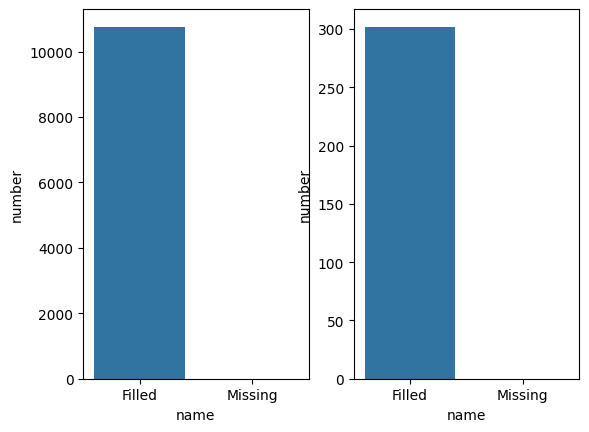

In [10]:
fig, axs = plt.subplots(1,2)
sns.barplot(data={'number':[len(bus_data_full['the_geom']) - bus_data_full['the_geom'].isna().sum(), bus_data_full['the_geom'].isna().sum()], 'name':['Filled', 'Missing']}, x='name', y='number', ax = axs[0])
sns.barplot(data={'number':[len(train_data_full['Location']) - train_data_full['Location'].isna().sum(), train_data_full['Location'].isna().sum()], 'name':['Filled', 'Missing']}, x='name', y='number', ax = axs[1])


<Axes: xlabel='name', ylabel='number'>

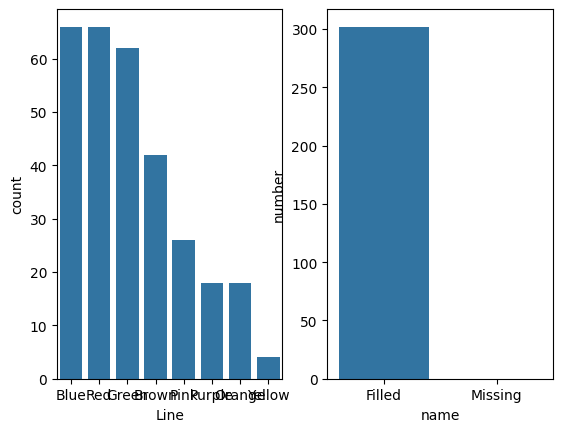

In [11]:
fig, axs = plt.subplots(1,2)
sns.barplot(data=train_data_full['Line'].value_counts(), ax=axs[0])
sns.barplot(data={'number':[len(train_data_full['Line']) - train_data_full['Line'].isna().sum(), train_data_full['Line'].isna().sum()], 'name':['Filled', 'Missing']}, x='name', y='number', ax = axs[1])

There are no missing data when it comes to the CTA datasets, although the location data for both the busses and trains must be cleaned from strings to numeric values.

The program data set was cleaned so that the Particpants Paid column was True or False. Additionally, a dataset consisting of only the programs that were listed as face-to-face and having location data was created. The distance from each program in this second dataset to its nearest bus and train station was then calculated using the haversine formula. This distance was calculated in feet. 

## Exploratory Data Analysis

For each analysis:

What did you do exactly? How did you solve the problem? Why did you think it would be successful? 

What problems did you anticipate? What problems did you encounter? Did the very first thing you tried work? 

Mention any code repositories (with citations) or other sources that you used, and specifically what changes you made to them for your project.

Note that you can write code to publish the results of the code, but hide the code using the yaml setting `#|echo: false`. For example, the code below makes a plot, but the code itself is not published with Quarto in the report.

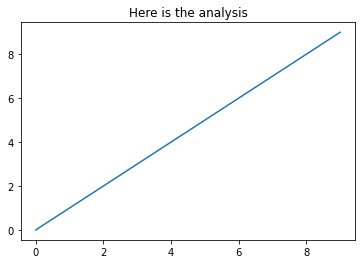

In [10]:
#| echo: false
import matplotlib.pyplot as plt
plt.plot(range(10));

### Analysis 1
*By \<Name of person doing the analysis>*

### Analysis 2
*By \<Name of person doing the analysis>*

### Analysis 3
*By \<Name of person doing the analysis>*

### Analysis 4
*By Owen Handelman*

Trying to address how location and meeting type affects assistance offered by a program, assitance must first be defined. I will be using transportation provided, has free food, participants paid, and scholarship available as the metrics of assitance. To answer the first question about how meeting type affects assistance provided we can compare online and face-to-face meetings on how everything other than transportation provided.

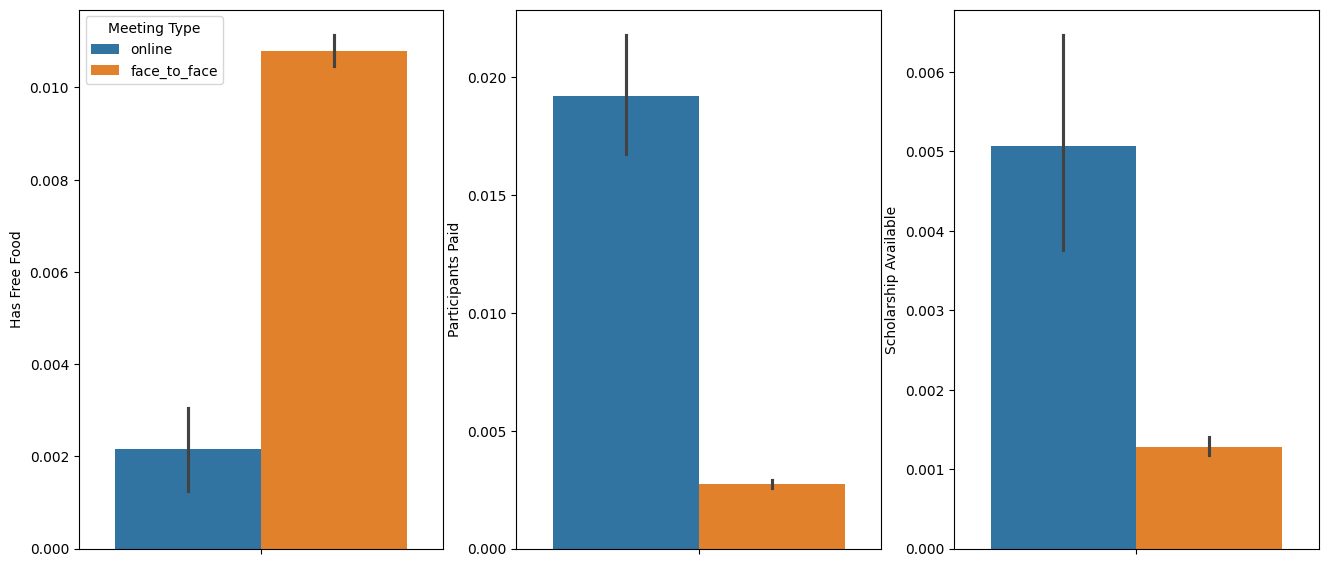

In [2]:
#| echo: false
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geodatasets
project_data_full = pd.read_csv('My_CHI._My_Future._Programs_20241113.csv')
bus_data_full = pd.read_csv('CTA_BusStops_20241118.csv')
train_data_full = pd.read_csv('CTA_-_System_Information_-_List_of__L__Stops_20241118.csv')
bus_lat_long = bus_data_full['the_geom'].str.slice(6).str.replace('(','').str.replace(')','').str.split(' ')
bus_data_full['Longitude'] = pd.to_numeric(bus_lat_long.apply(lambda x: x[0]))
bus_data_full['Latitude'] = pd.to_numeric(bus_lat_long.apply(lambda x: x[1]))
bus_data = bus_data_full.loc[:, ['PUBLIC_NAM', 'Longitude', 'Latitude']]
train_lat_long = train_data_full['Location'].str.replace('(','').str.replace(')','').str.split(',')
train_data_full['Longitude'] = pd.to_numeric(train_lat_long.apply(lambda x: x[1]))
train_data_full['Latitude'] = pd.to_numeric(train_lat_long.apply(lambda x: x[0]))
train_data_full['Line'] = train_data_full.apply(lambda x: 'Red' if x['RED'] == True else 'Blue' if x['BLUE'] == True else 'Green' if x['G'] == True
                                                else 'Brown' if x['BRN'] == True else 'Purple' if x['P'] == True else 'Yellow' if x['Y'] == True
                                                else 'Pink' if x['Pnk'] == True else 'Orange', axis = 1)
train_data = train_data_full.loc[:, ['STATION_DESCRIPTIVE_NAME', 'Longitude', 'Latitude', 'Line']]
project_data = project_data_full.loc[:,['Program ID', 'Meeting Type', 'Scholarship Available', 'Participants Paid', 'Transport Provided', 'Has Free Food', 'Latitude', 'Longitude']]
project_data['Participants Paid'] = project_data['Participants Paid'].apply(lambda x: True if x == 'Paid, Type Unknown' else False if x == 'Not Paid' else np.nan)
project_data_f2f = project_data[~project_data_full['Location'].isna()]
project_data_f2f = project_data_f2f[project_data_f2f['Meeting Type'] == 'face_to_face']
project_data_f2f.drop_duplicates(subset='Program ID', inplace=True)
fig, axs = plt.subplots(1,3,figsize=(16,7))
sns.barplot(project_data, y='Has Free Food', hue = 'Meeting Type', ax=axs[0])
sns.barplot(project_data, y='Participants Paid', hue = 'Meeting Type', ax=axs[1])
sns.barplot(project_data, y='Scholarship Available', hue = 'Meeting Type', ax=axs[2])
axs[1].get_legend().remove()
axs[2].get_legend().remove()

We can see that online programs are more likely to assist financialy than face-to-face programs, while face-to-face programs are more likely to have free food. Face-to-face programs being more likely to have free food is somewhat expected. It is important to note that the percentage/proportion of programs offering any kind of assistance is very low.

Text(0.5, 1.0, 'CTA Train Station Map')

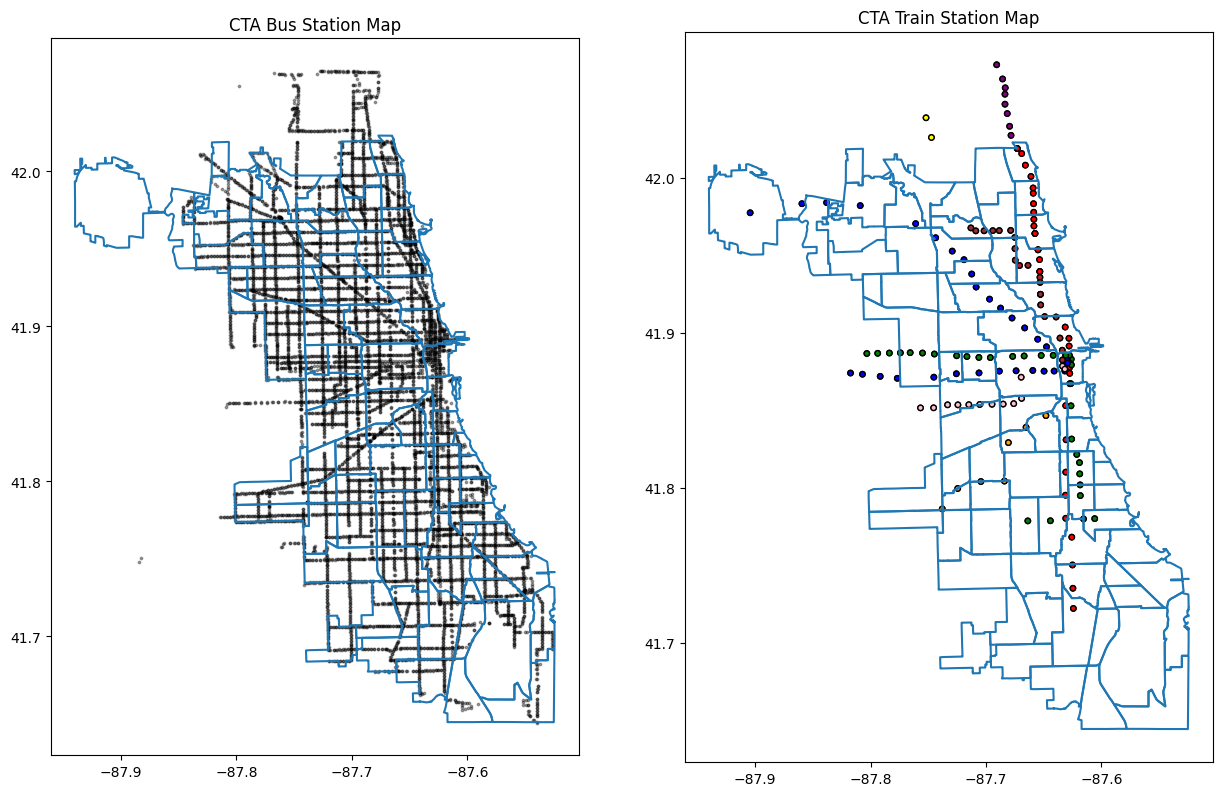

In [3]:
#| echo: false
radius = 3957.297 # estimation of the Earth's radius at Chicago's Latitude in miles
radius *= 5280 # radius estimate converted to feet
bus_long = np.deg2rad(bus_data['Longitude']) # preparing bus stop data for haversine
bus_lat = np.deg2rad(bus_data['Latitude'])
def dist_to_closest_bus_station(lat, long): # finds minimum haversine distance between program location and a bus stop
    program_long = np.deg2rad(long)
    program_lat = np.deg2rad(lat)
    diff_long = bus_long - program_long
    diff_lat = bus_lat- program_lat

    add = np.cos(program_lat) * np.cos(bus_lat) * np.sin(diff_long * 0.5) ** 2
    d = np.sin(diff_lat * 0.5) ** 2 + add
    h = 2 * radius * np.arcsin(np.sqrt(d))
    return(h.min())

train_long = np.deg2rad(train_data['Longitude']) # prepares train stop data
train_lat = np.deg2rad(train_data['Latitude'])
def dist_to_closest_train_station(lat, long): # finds distance to nearest train station in feet using haversine
    program_long = np.deg2rad(long)
    program_lat = np.deg2rad(lat)
    diff_long = train_long - program_long
    diff_lat = train_lat- program_lat

    add = np.cos(program_lat) * np.cos(train_lat) * np.sin(diff_long * 0.5) ** 2
    d = np.sin(diff_lat * 0.5) ** 2 + add
    h = 2 * radius * np.arcsin(np.sqrt(d))
    idx = h.idxmin()
    return(pd.Series([h.min(), train_data['Line'][idx]]))
project_data_f2f['Distance to Closest Bus Station (ft)'] = project_data_f2f.apply(lambda row: dist_to_closest_bus_station(row.Latitude, row.Longitude), axis = 1)
project_data_f2f[['Distance to Closest Train Station (ft)', 'Closest Train Line']] = project_data_f2f.apply(lambda row: dist_to_closest_train_station(row.Latitude, row.Longitude), axis = 1)
project_data_f2f = project_data_f2f.sort_values('Distance to Closest Bus Station (ft)', ascending=False)
project_data_f2f = project_data_f2f.copy().iloc[4:] 
chicago = gpd.read_file(geodatasets.get_path('geoda.chicago_commpop'))
fig, axes = plt.subplots(1,2,figsize=(15,10))
chicago.boundary.plot(ax=axes[0])
axes[0].scatter(x= bus_data['Longitude'], y = bus_data['Latitude'], s = 3, alpha = 0.35, color ='black')
axes[0].set_title('CTA Bus Station Map')
chicago.boundary.plot(ax=axes[1])
train_color_dict = {'Pink': 'pink', 'Green':'green', 'Blue':'blue', 'Brown':'brown', 'Purple':'purple', 'Red':'red', 'Orange':'orange', 'Yellow':'yellow'}
axes[1].scatter(x= train_data['Longitude'], y = train_data['Latitude'], s = 15, c=[train_color_dict[cat] for cat in train_data['Line']], edgecolors='black')
axes[1].set_title('CTA Train Station Map')

Looking at the maps of CTA bus and train stations, it is evident that bus stations are much more uniformly spread out across the city while the train stations are concentrated on getting indviduals downtown. Given the difference in distribution it is reasonable to conclude that a program's proximity to a bus station means something different than its proximity to a train station in terms of overall connectednes to the CTA and public transit in general.

Text(0.5, 1.0, 'Programs That Do Provided Transportation')

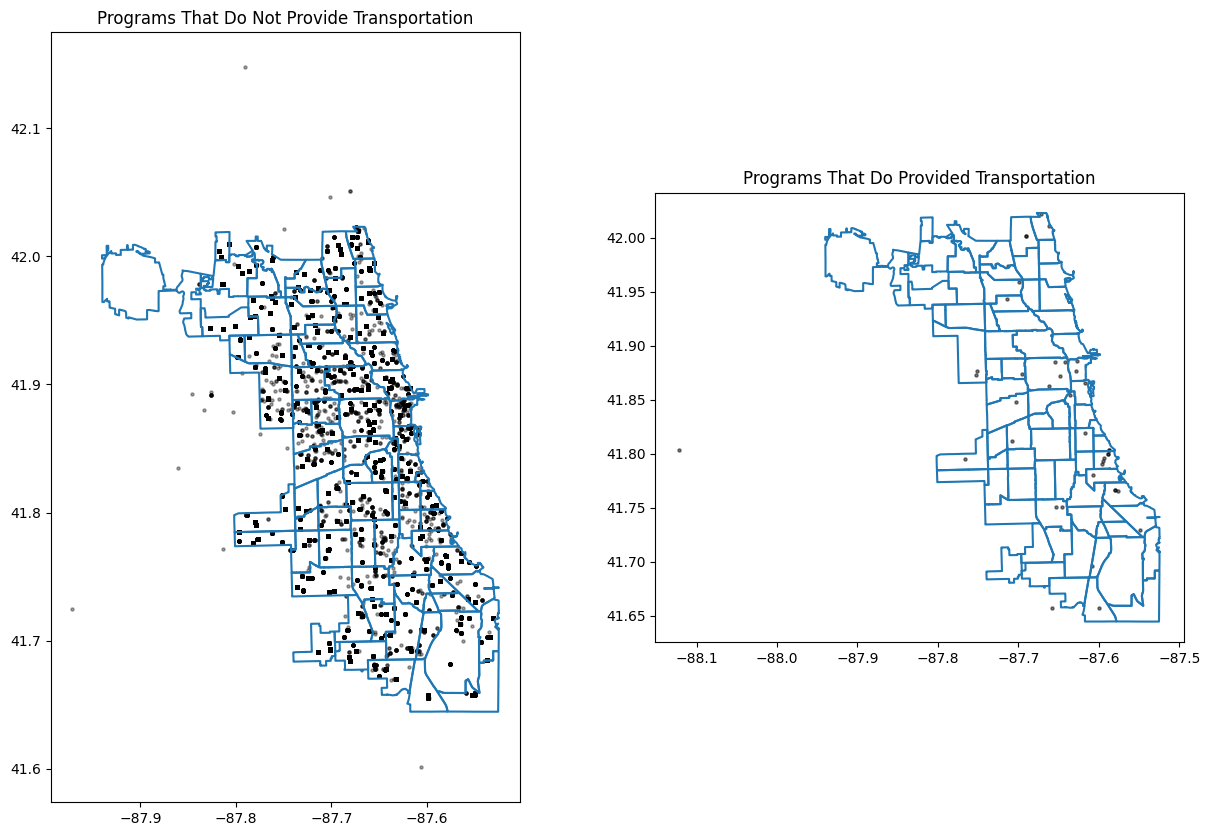

In [4]:
#| echo: false
f2f_transport_yes = project_data_f2f[project_data_f2f['Transport Provided'] == True]
f2f_transport_no = project_data_f2f[project_data_f2f['Transport Provided'] == False]

chicago = gpd.read_file(geodatasets.get_path('geoda.chicago_commpop'))
fig, axes = plt.subplots(1,2,figsize=(15,10))
chicago.boundary.plot(ax=axes[0])
axes[0].scatter(x= f2f_transport_no['Longitude'], y = f2f_transport_no['Latitude'], s = 5, alpha = 0.35, color ='black')
axes[0].set_title('Programs That Do Not Provide Transportation')
chicago.boundary.plot(ax=axes[1])
axes[1].scatter(x= f2f_transport_yes['Longitude'], y = f2f_transport_yes['Latitude'], s = 5, alpha=0.5, c='black')
axes[1].set_title('Programs That Do Provided Transportation')

The maps of programs that do and do not offer transportation offer insight when looking at the locations of programs that provide transportation. Programs that do not provide transportation appear to be evently distributed accross Chicago while programs that do provide transportation appear to be concentrated in the downtown area or along primary routes connected to the downtown area.

Text(0.5, 1.0, 'Programs That Do Provided Transportation with CTA Train Stations')

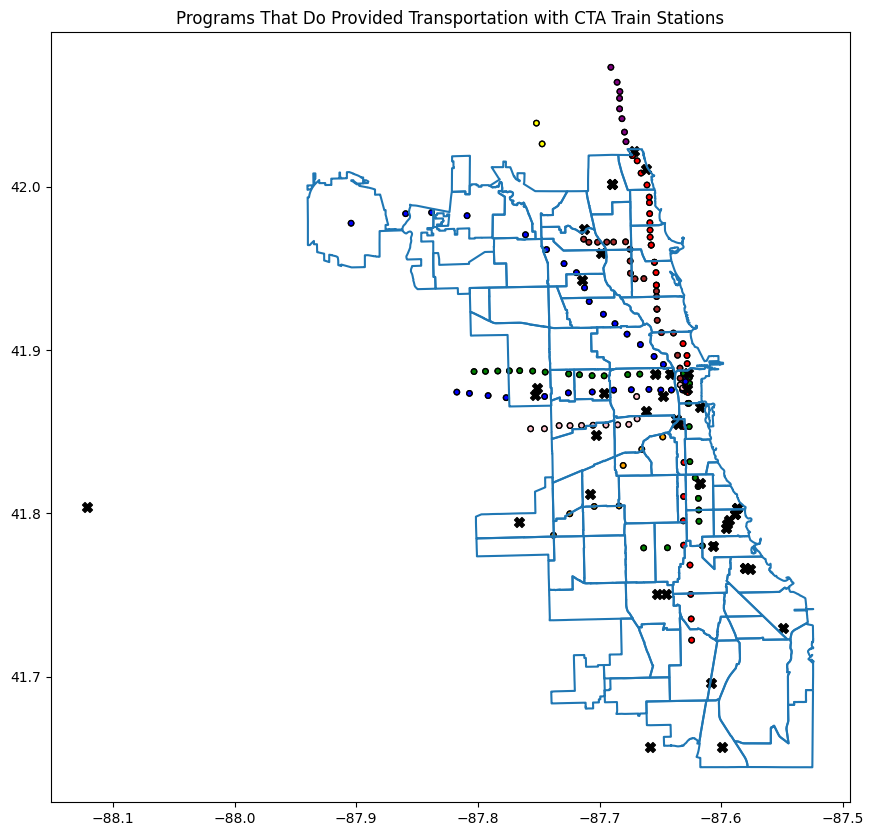

In [6]:
#| echo: false
chicago = gpd.read_file(geodatasets.get_path('geoda.chicago_commpop'))
fig, axes = plt.subplots(figsize=(15,10))
chicago.boundary.plot(ax=axes)
train_color_dict = {'Pink': 'pink', 'Green':'green', 'Blue':'blue', 'Brown':'brown', 'Purple':'purple', 'Red':'red', 'Orange':'orange', 'Yellow':'yellow'}
axes.scatter(x= train_data['Longitude'], y = train_data['Latitude'], s = 15, c=[train_color_dict[cat] for cat in train_data['Line']], edgecolors='black')
axes.scatter(x= f2f_transport_yes['Longitude'], y = f2f_transport_yes['Latitude'], s = 50, c='black', marker='X')
axes.set_title('Programs That Do Provided Transportation with CTA Train Stations')

Plotting the programs that do provide transportation with CTA train stations appears to confirm the above suspicion. With the notable exception of the program well west of Chicago, and the programs south of the train system, programs that provide transportation appear to be located rooughly along train lines which can be considered the major transportation routes (for people).

Calculating distance between all programs and their closest bus and train station using the haversine formula allows us to now analyze any relation between distance to public transport and assistance. Looking first at the above relationship between programs that provide transportation and their closest train line we see:

Text(0.5, 1.0, 'Programs that provide Transport')

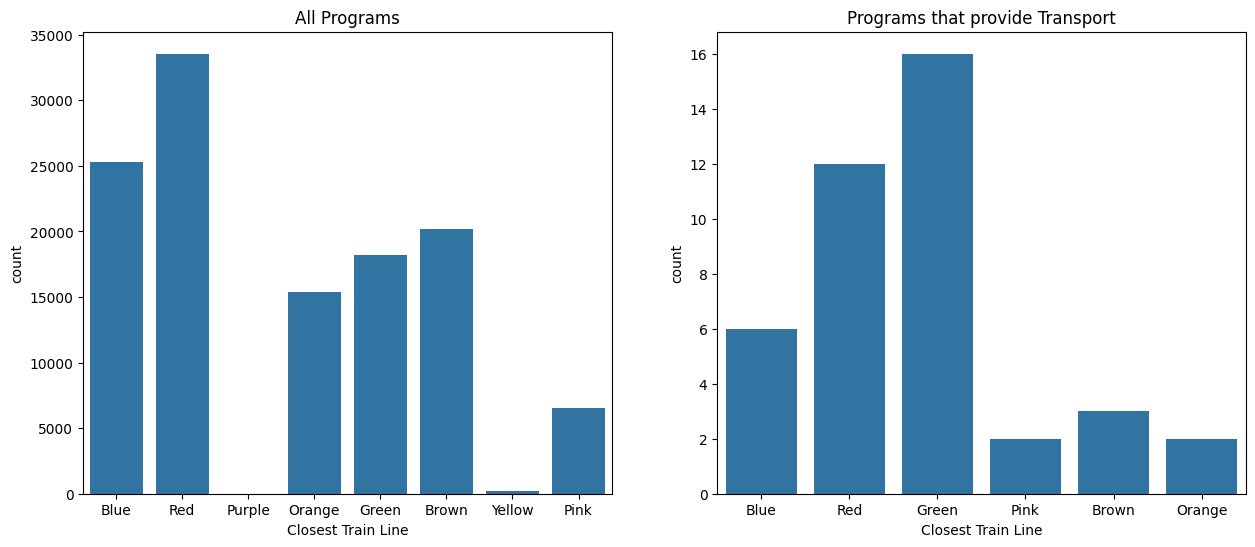

In [9]:
#| echo: false
fig, axs = plt.subplots(1,2,figsize=(15,6))
sns.countplot(project_data_f2f, x = 'Closest Train Line', ax= axs[0])
sns.countplot(project_data_f2f[project_data_f2f['Transport Provided'] == True], x = 'Closest Train Line', ax= axs[1])
axs[0].set_title('All Programs')
axs[1].set_title('Programs that provide Transport')

The concentration of programs that provide transportation downtown or along major transportation routes can be seen in the difference in distribution of closest train line when comparing all programs to only those that provide transportation. Programs that provide transportation are more likely to be closer to the Green line than all programs, which makes sense as the green line runs through downtown Chicago (and West).

Moving on to differences in average distance to closest transportation station between programs that offer assitance and those that do not.

<Axes: xlabel='Scholarship Available', ylabel='Distance to Closest Bus Station (ft)'>

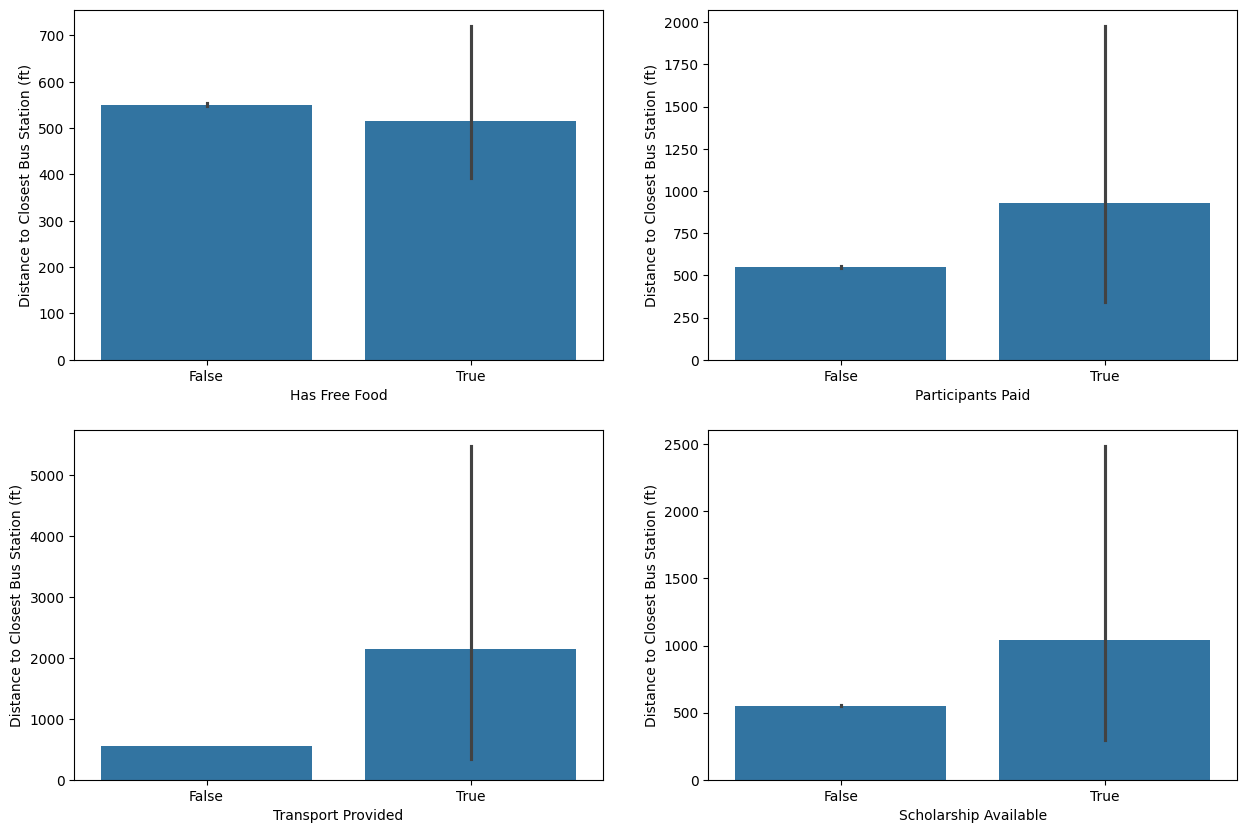

In [8]:
#| echo: false
fig, axs = plt.subplots(2,2,figsize=(15,10))
sns.barplot(data=project_data_f2f, x='Has Free Food', y='Distance to Closest Bus Station (ft)', ax=axs[0,0])
sns.barplot(data=project_data_f2f, x='Participants Paid', y='Distance to Closest Bus Station (ft)', ax=axs[0,1])
sns.barplot(data=project_data_f2f, x='Transport Provided', y='Distance to Closest Bus Station (ft)', ax=axs[1,0])
sns.barplot(data=project_data_f2f, x='Scholarship Available', y='Distance to Closest Bus Station (ft)', ax=axs[1,1])

We can see that there does not appear to be a significant difference in average distance to nearest bus station when comparing programs that provide assistance and those that do not (only comparing programs based on one aspect of assistance). One possible explanation for this observation is that the apparent even distribution of the bus stations means looking at distance to nearest bus station is not important. Another possible explanation is that there are actual differences in distance to nearest bus station but the low sample size and high variability cause the margin of error to be too large to find this actual difference. Either way the proximity of all the programs that do not provide assistance to their nearest bus station indicates that this may be an area that is underutilized by programs, especially when it comes to providing transportation. It is clearly shown that programs that do not provide transportation are pretty close to their nearest bus station (~700ft from the graph).

Looking at distance to nearest train station we find:

<Axes: xlabel='Scholarship Available', ylabel='Distance to Closest Train Station (ft)'>

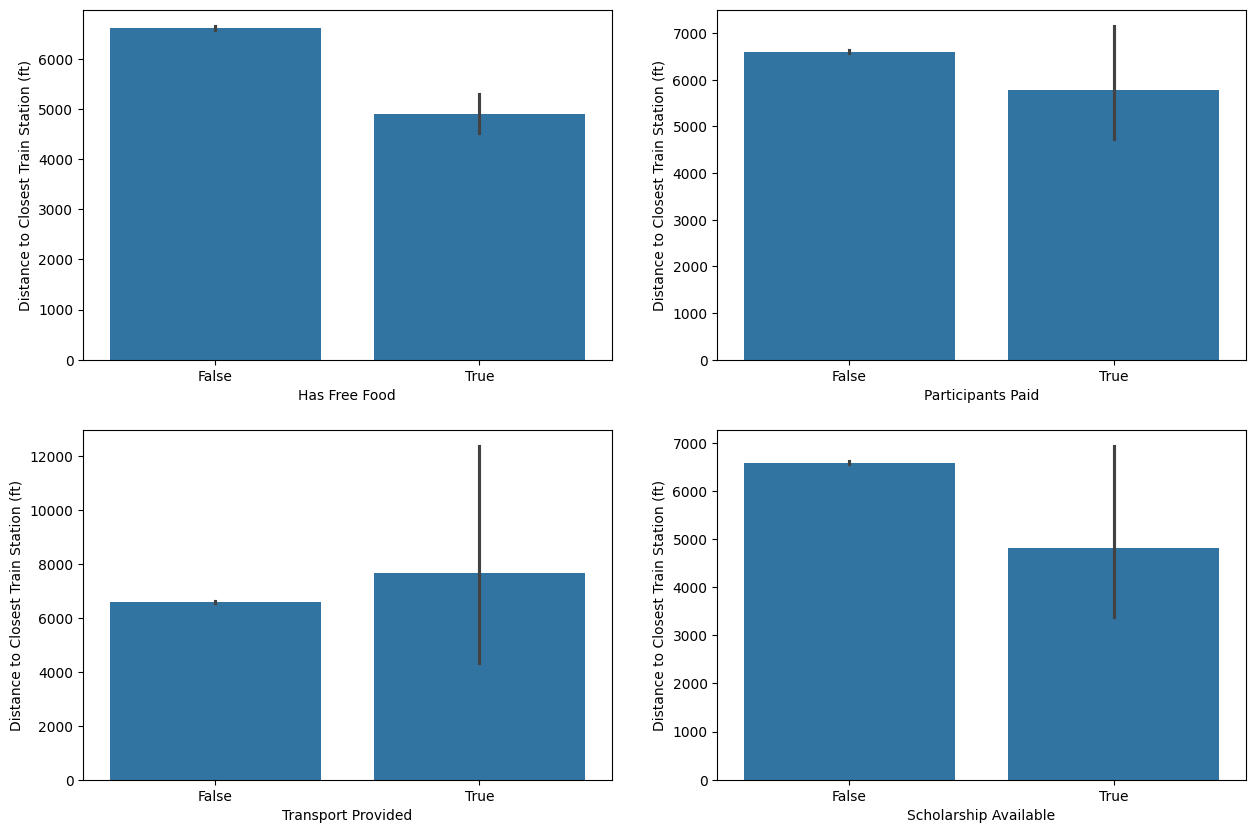

In [7]:
#| echo: false
fig, axs = plt.subplots(2,2,figsize=(15,10))
sns.barplot(data=project_data_f2f, x='Has Free Food', y='Distance to Closest Train Station (ft)', ax=axs[0,0])
sns.barplot(data=project_data_f2f, x='Participants Paid', y='Distance to Closest Train Station (ft)', ax=axs[0,1])
sns.barplot(data=project_data_f2f, x='Transport Provided', y='Distance to Closest Train Station (ft)', ax=axs[1,0])
sns.barplot(data=project_data_f2f, x='Scholarship Available', y='Distance to Closest Train Station (ft)', ax=axs[1,1])

Only one piece of assitance has a significant difference, with programs that have free food being closer to their nearest train station than those that do not. Overall average distance to nearest train station for any type of program is around a mile.

Overall it can be seen that there appears to be an underutilization of the CTA public transportation system to encourage participation in programs. Most programs are well within walking distance to their closest bus stop.

## Other sections

You are welcome to introduce additional sections or subsections, if required, to address your questions in detail. For example, you may briefly discuss potential future work that the research community could focus on to make further progress in the direction of your project's topic.

## Conclusions

Do the individual analysis connect with each other to answer a bigger question? If yes, explain.

Access to programs could be more equitable if programs were encouraged to subsidize bus and maybe train fair to allow individuals greater access to programs, including program types that may not be offered in their area. Online programs may be better suited to allowing greater equity accross economic ability as they are more likely than face-to-face programs to offer financial assistance.

## Recommendations to stakeholder(s)
What are the action items for the stakeholder(s) based on your analysis? Be as precise as possible. The stakeholder(s) are depending on you to come up with practically implementable recommendations, instead of having to think for themselves.

Do the stakeholder(s) need to be aware about some limitations of your analysis? Can your analysis be directly used by the stakeholder(s) to obtain the expected benefit / make decisions, or do they need to do some further analysis based on their own, or do they need to repeat your analysis on a more recent data for the results to be applicable? 

We recommend enouraging more online programs to offer financial assistance as a way of enabling more economically-disadvantaged individuals to access programs increasing equity. This encouragement can be direct pressure to online programs but also the inclusion of more of them. Additionally, we recommend encouraging programs to subsidize CTA transit as a means of providing transportation assistance as most programs are within walking distance of a bus stop. Greater transporation assistance would help to reduce disparities in program and program type availability accross the different neighborhoods of Chicago.

## References {-}

List and number all bibliographical references. When referenced in the text, enclose the citation number in square brackets, for example [1].

[1] Authors. The frobnicatable foo filter, 2014. Face and Gesture submission ID 324. Supplied as additional material
fg324.pdf. 3


## Appendix {-}

You may put additional stuff here as Appendix. You may refer to the Appendix in the main report to support your arguments. However, the appendix section is unlikely to be checked while grading, unless the grader deems it necessary.